# Vehicle Platoon Model


## Model description

This benchmark considers a platoon of three vehicles following each
other. This benchmark considers loss of communication between vehicles. The model
has two modes, connected and disconnected.
Three scenarios are considered for the loss of communication:

**PLAA01 (arbitrary loss)** The loss of communication can occur at any time. This
      includes the possibility of no communication at all.

**PLADxy (loss at deterministic times)** The loss of communication occurs at fixed
      points in time, which are determined by clock constraints ``c_1`` and ``c_2``.
      The clock t is reset when communication is lost and when it is re-established.
      Note that the transitions have must-semantics, i.e., they take place as soon
      as possible. We will consider `PLAD01: c1 = c_2 = 5`.

**PLANxy (loss at nondeterministic times)** The loss of communication occurs at
      any time ``t ∈ [t_b, t_c]``. The clock t is reset when communication is lost
      and when it is reestablished. Communication is reestablished at any time
      ``t ∈ [0, t_r]``. This scenario covers loss of communication after an
      arbitrarily long time ``t ≥ t_c`` by reestablishing communication in zero time.
      We will consider `PLAN01: tb = 10, tc = 20, tr = 20`.

The Julia model is developed next. It's convenient to create two independent
functions, `platoon_connected` and `platoon_disconnected`, which describe the
dynamics of the connected (resp. disconnected) modes. These functions are
connected in the `platoon` function using a hybrid automaton with two modes
and two discrete transitions, see the following diagram.

![](https://github.com/JuliaReach/ReachabilityAnalysis.jl/blob/master/examples/Platoon/platoon_hybrid.png?raw=true)

On the left, the system can switch arbitrarily between the modes.
In the middle, mode switches are only possible at given points in time, i.e. deterministic switching.
On the right, mode switches are only possible during given time intervals.
In this notebook we will only consider the case of deterministic switching.

### Dynamics of the "connected" platoon

In [1]:
using ReachabilityAnalysis, SparseArrays, Symbolics

const var = @variables x[1:9] t

function platoon_connected(; deterministic_switching::Bool=true,
                             c1=5.0)  # clock constraints
    n = 9 + 1

    # x' = Ax + Bu + c
    A = Matrix{Float64}(undef, n, n)
    A[1, :] = [0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0]
    A[2, :] = [0, 0, -1.0, 0, 0, 0, 0, 0, 0, 0]
    A[3, :] = [1.6050, 4.8680, -3.5754, -0.8198, 0.4270, -0.0450, -0.1942,  0.3626, -0.0946, 0.]
    A[4, :] = [0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0,]
    A[5, :] = [0, 0, 1.0, 0, 0, -1.0, 0, 0, 0, 0]
    A[6, :] = [0.8718, 3.8140, -0.0754,  1.1936, 3.6258, -3.2396, -0.5950,  0.1294, -0.0796, 0.]
    A[7, :] = [0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0]
    A[8, :] = [0, 0, 0, 0, 0, 1.0, 0, 0, -1.0, 0]
    A[9, :] = [0.7132, 3.5730, -0.0964,  0.8472, 3.2568, -0.0876,  1.2726,  3.0720, -3.1356, 0.]
    A[10, :] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0]; # t' = 1

    if deterministic_switching
        invariant = HalfSpace(t <= c1, var)
    else
        invariant = Universe(n)
    end

    # acceleration of the lead vehicle + time
    B = sparse([2], [1], [1.0], n, 1)
    U = Hyperrectangle(low=[-9.], high=[1.])
    c = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0]
    @system(x' = Ax + Bu + c, x ∈ invariant, u ∈ U)
end

platoon_connected (generic function with 1 method)

### Dynamics of the "disconnected" platoon

In [2]:
function platoon_disconnected(; deterministic_switching::Bool=true,
                                c2=5.0)  # clock constraints
    n = 10 # 9 dimensions + time

    # x' = Ax + Bu + c
    A = Matrix{Float64}(undef, n, n)
    A[1, :] = [0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0]
    A[2, :] = [0, 0, -1.0, 0, 0, 0, 0, 0, 0, 0]
    A[3, :] = [1.6050, 4.8680, -3.5754, 0, 0, 0, 0, 0, 0, 0]
    A[4, :] = [0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0,]
    A[5, :] = [0, 0, 1.0, 0, 0, -1.0, 0, 0, 0, 0]
    A[6, :] = [0, 0, 0,  1.1936, 3.6258, -3.2396, 0, 0, 0, 0.]
    A[7, :] = [0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0]
    A[8, :] = [0, 0, 0, 0, 0, 1.0, 0, 0, -1.0, 0]
    A[9, :] = [0.7132, 3.5730, -0.0964,  0.8472, 3.2568, -0.0876,  1.2726,  3.0720, -3.1356, 0.]
    A[10, :] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0]; # t' = 1

    if deterministic_switching
        invariant = HalfSpace(t <= c2, var)
    else
        invariant = Universe(n)
    end

    # acceleration of the lead vehicle + time
    B = sparse([2], [1], [1.0], n, 1)
    U = Hyperrectangle(low=[-9.], high=[1.])
    c = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0]
    @system(x' = Ax + Bu + c, x ∈ invariant, u ∈ U)
end

platoon_disconnected (generic function with 1 method)

### Hybrid system

In [3]:
function platoon(; deterministic_switching::Bool=true,
                   c1=5.0,  # clock constraints
                   c2=5.0,  # clock constraints
                   tb=10.0,  # lower bound for loss of communication
                   tc=20.0, tr=20.0) # upper bound for loss of communication (tc) and reset time (tr)

    # three variables for each vehicle, (ei, d(et)/dt, ai) for
    # (spacing error, relative velocity, speed), and the last dimension is time
    n = 9 + 1

    # transition graph
    automaton = LightAutomaton(2)
    add_transition!(automaton, 1, 2, 1)
    add_transition!(automaton, 2, 1, 2)

    # modes
    mode1 = platoon_connected(deterministic_switching=deterministic_switching, c1=c1)
    mode2 = platoon_disconnected(deterministic_switching=deterministic_switching, c2=c2)
    modes = [mode1, mode2]

    # common reset
    reset = Dict(n => 0.)

    # transition l1 -> l2
    if deterministic_switching
        guard = Hyperplane(t == c1, var)
    else
        guard = HPolyhedron([tb <= t, t <= tc], var)
    end
    t1 = ConstrainedResetMap(n, guard, reset)

    # transition l2 -> l1
    if deterministic_switching
        guard = Hyperplane(t == c2, var)
    else
        guard = HalfSpace(t <= tr, var)
    end
    t2 = ConstrainedResetMap(n, guard, reset)
    resetmaps = [t1, t2]

    H = HybridSystem(automaton, modes, resetmaps, [AutonomousSwitching()])

    # initial condition is at the orgin in mode 1
    X0 = BallInf(zeros(n), 0.0)
    initial_condition = [(1, X0)]

    return IVP(H, initial_condition)
end

platoon (generic function with 1 method)

## Safety specifications

The verification goal is to check whether the minimum distance between
vehicles is preserved. The choice of the coordinate system is such that the
minimum distance is a negative value.

**BNDxy**: Bounded time (no explicit bound on the number of transitions): For all ``t ∈ [0, 20] [s]``,

   - ``x_1(t) ≥ −d_{min} [m]``
   - ``x_4(t) ≥ −d_{min} [m]``
   - ``x_7(t) ≥ −d_{min} [m]``

**BND42**: ``d_{min} = 42``.

**BND30**: ``d_{min} = 30``.

In [4]:
function dmin_specification(sol, dmin)
    return (-ρ(sparsevec([1], [-1.0], 10), sol) > -dmin) &&
           (-ρ(sparsevec([4], [-1.0], 10), sol) > -dmin) &&
           (-ρ(sparsevec([7], [-1.0], 10), sol) > -dmin)
end

dmin_specification (generic function with 1 method)

## Results

We will only consider the case of deterministic switching in this notebook. We consider two
scenarios of increasing difficulty, BND42 and BND30.

In [5]:
prob_PLAD01 = platoon();

const boxdirs = BoxDirections(10)
const octdirs = OctDirections(10);

 ### PLAD01 - BND42

This scenario can be solved using a hyperrectangular set representation with step
size ``δ = 0.01``.  We use a template that contains all box (i.e., canonical)
directions in the ambient space of the state-space, ``\mathbb{R}^{10}``.
There are ``20`` such directions, two for each coordinate:

In [6]:
length(boxdirs)

20

In [7]:
alg = BOX(δ=0.01)
sol_PLAD01_BND42 = solve(prob_PLAD01,
                         alg=alg,
                         clustering_method=BoxClustering(1),
                         intersection_method=TemplateHullIntersection(boxdirs),
                         intersect_source_invariant=false,
                         tspan = (0.0 .. 20.0));

Let's verify that the specification holds:

In [8]:
dmin_specification(sol_PLAD01_BND42, 42)

true

In more detail we can check how is the flowpipe from violating the property.
The specification requires that each of the follwing quantities is greater
than `-dmin = -42`.

Minimum of ``x_1(t)``:

In [9]:
-ρ(sparsevec([1], [-1.0], 10), sol_PLAD01_BND42)

-41.33920509152303

Minimum of ``x_4(t)``:

In [10]:
-ρ(sparsevec([4], [-1.0], 10), sol_PLAD01_BND42)

-35.51410505514701

Minimum of ``x_7(t)``:

In [11]:
-ρ(sparsevec([7], [-1.0], 10), sol_PLAD01_BND42)

-21.564982098017076

We plot variable ``x_1`` vs time.

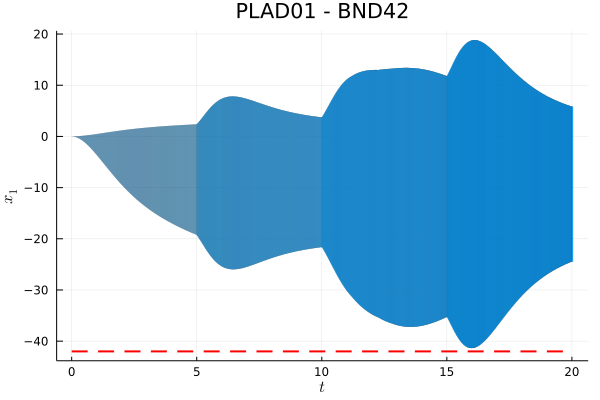

In [12]:
using Plots, LaTeXStrings

plot(sol_PLAD01_BND42, vars=(0, 1), xlab=L"t", ylab=L"x_1", title="PLAD01 - BND42", lw=0.1)
plot!(x->x, x->-42., 0., 20., linewidth=2, color="red", linestyle=:dash, leg=nothing)

 ### PLAD01 - BND30

Note that the previous solution obtained for `PLAD01 - BND42` does not verify the
`BND30` specifications since, for example,
the minimum of variable ``x_4(t)`` is ``≈ -35.52``, which
is below the given bound ``-d_{min} = -30``. As a consequence, to prove the safety
properties for this scenario we have to use a solver with more precision.
Instead of the `BOX` algorithm, we propose to use `LGG09` with step-size
``δ=0.03`` and octagonal template directions. There are 200 such directions:

In [13]:
length(octdirs)


alg = LGG09(δ=0.03, template=octdirs, approx_model=Forward(setops=octdirs));
sol_PLAD01_BND30 = solve(prob_PLAD01,
                         alg=alg,
                         clustering_method=LazyClustering(1),
                         intersection_method=TemplateHullIntersection(octdirs),
                         intersect_source_invariant=false,
                         tspan = (0.0 .. 20.0));

Verifying that the specification holds:

In [14]:
dmin_specification(sol_PLAD01_BND30, 30)

true

Let's check in more detail how close is the flowpipe to the safety conditions:

Minimum of ``x_1(t)``:

In [15]:
-ρ(sparsevec([1], [-1.0], 10), sol_PLAD01_BND30)

-29.86272157525803

Minimum of ``x_4(t)``:

In [16]:
-ρ(sparsevec([4], [-1.0], 10), sol_PLAD01_BND30)

-26.167902001889427

Minimum of ``x_7(t)``:

In [17]:
-ρ(sparsevec([7], [-1.0], 10), sol_PLAD01_BND30)

-12.696657569596823

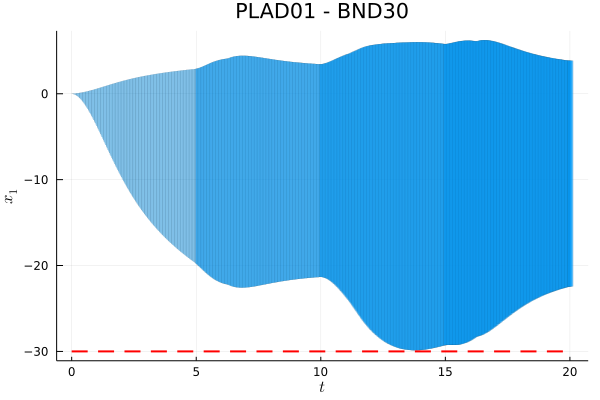

In [18]:
plot(sol_PLAD01_BND30, vars=(0, 1), xlab=L"t", ylab=L"x_1", title="PLAD01 - BND30", lw=0.1)
plot!(x->x, x->-30., 0., 20., linewidth=2, color="red", linestyle=:dash, leg=nothing)

## References

[^]: